In [2]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as npl
from scipy.optimize import minimize
import math as math
from itertools import combinations
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import csv
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import griddata
from scipy.spatial import distance_matrix
from scipy import interpolate
from sklearn.model_selection import KFold
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic,ExpSineSquared,PairwiseKernel
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import emcee
from scipy.stats import uniform
from emcee.moves import WalkMove,DEMove

In [3]:
columns = ["x","y","z","w","data","error"]
datatab = pd.read_table("Updateddata.txt",names = columns)
datatab

x = datatab['x']
y = datatab['y']
z = datatab['z']
w = datatab['w']
data = datatab['data']
error = datatab['error']


# First dataset 
datam1 = datatab[0:250]
xm1 = datam1['x'].values
ym1 = datam1['y'].values
zm1 = datam1['z'].values
wm1 = datam1['w'].values
dm1 = datam1['data'].values
em1 = datam1['error'].values
X1 = np.column_stack((xm1, ym1, zm1, wm1))
X1_train, X1_test, D1_train, D1_test, E1_train, E1_test = train_test_split(X1,dm1.reshape(-1, 1),em1,train_size=0.8,random_state=1)

# Second dataset
datam2 = datatab[250:500]
xm2 = datam2['x'].values
ym2 = datam2['y'].values
zm2 = datam2['z'].values
wm2 = datam2['w'].values
dm2 = datam2['data'].values
em2 = datam2['error'].values
X2 = np.column_stack((xm2, ym2, zm2, wm2))
X2_train, X2_test, D2_train, D2_test, E2_train, E2_test = train_test_split(X2, dm2.reshape(-1,1),em2, train_size=0.8, random_state=3)

# Third dataset
datam3 = datatab[500:750]
xm3 = datam3['x'].values
ym3 = datam3['y'].values
zm3 = datam3['z'].values
wm3 = datam3['w'].values
dm3 = datam3['data'].values
em3 = datam3['error'].values
X3 = np.column_stack((xm3, ym3, zm3, wm3))
X3_train, X3_test, D3_train, D3_test,E3_train, E3_test = train_test_split(X3, dm3.reshape(-1,1),em3, train_size=0.8, random_state=5)

# Fourth dataset
datam4 = datatab[750:]
xm4 = datam4['x'].values
ym4 = datam4['y'].values
zm4 = datam4['z'].values
wm4 = datam4['w'].values
dm4 = datam4['data'].values
em4 = datam4['error'].values
X4 = np.column_stack((xm4, ym4, zm4, wm4))
X4_train, X4_test, D4_train, D4_test,E4_train, E4_test = train_test_split(X4, dm4.reshape(-1,1),em4, train_size=0.8, random_state=7)


X = np.column_stack((x,y, z, w))
D = np.concatenate((dm1,dm2,dm3,dm4))
E = np.concatenate((em1,em2,em3,em4))

X_train = np.concatenate((X1_train,X2_train,X3_train,X4_train))
X_test = np.concatenate((X1_test,X2_test,X3_test,X4_test))
D_train = np.concatenate((D1_train,D2_train,D3_train,D4_train))
D_test = np.concatenate((D1_test,D2_test,D3_test,D4_test))
#E_train = np.concatenate((E1_train.reshape(-1,1),E2_train.reshape(-1,1),E3_train.reshape(-1,1),E4_train.reshape(-1,1)))
E_train = np.concatenate((E1_train,E2_train,E3_train,E4_train))
E_test = np.concatenate((E1_test,E2_test,E3_test,E4_test))

In [4]:
### White Kernel. No error Knowledge
bounds_l = ((.08, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  # Fix l1 bounds not get so close to 0
guess_l = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
noiselvl =1.0
noisebounds=(E.mean() - 1e-8, E.mean() + 1e-8)

kernel1 = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
RBF(length_scale=guess_l, length_scale_bounds=bounds_l)+WhiteKernel(noiselvl)
gpr1 = GaussianProcessRegressor(kernel=kernel1,normalize_y=True, n_restarts_optimizer=2)#,noise_level_bounds = noisebounds)
gpr1.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr1.kernel_}")

Fitted Kernel: 0.868**2 * RBF(length_scale=[0.111, 0.11, 1.06, 1.79]) + WhiteKernel(noise_level=0.00798)


In [5]:
### White Kernel. Incorporating error knowledge for bounds
bounds_l = ((.08, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  # Fix l1 bounds not get so close to 0
guess_l = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)
noiselvl =1.0
noisebounds=(E.mean() - 1e-1, E.mean() + 1e-1)
### noisebounds are fatter the more you u reduce the delta and get the noisebounds to be stuck on E.mean()

kernel2 = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * \
RBF(length_scale=guess_l, length_scale_bounds=bounds_l)+WhiteKernel( E.mean(),noise_level_bounds = noisebounds)
gpr2 = GaussianProcessRegressor(kernel=kernel2,normalize_y=True, n_restarts_optimizer=2)
gpr2.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr2.kernel_}")

Fitted Kernel: 0.947**2 * RBF(length_scale=[0.399, 0.88, 1.04, 3.42]) + WhiteKernel(noise_level=0.543)


c:\Users\seanw\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.5427551099745436. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [15]:
# alpha = E_train^2
bounds_l = ((.08, 10), (1e-2, 10.0), (1e-2, 10.0), (1e-2, 10.0))  # Fix l1 bounds not get so close to 0
guess_l = (1,1,1,1)
guess_signal_var = 1.0
bounds_signal_var = (1e-20, 1e20)

kernel3 = C(constant_value=guess_signal_var, constant_value_bounds=bounds_signal_var) * RBF(length_scale=guess_l, length_scale_bounds=bounds_l)

gpr3 = GaussianProcessRegressor(kernel=kernel3, alpha=E_train**2,normalize_y=True, n_restarts_optimizer=10)
gpr3.fit(X_train, D_train)
print(f"Fitted Kernel: {gpr3.kernel_}")

Fitted Kernel: 0.776**2 * RBF(length_scale=[0.13, 0.706, 0.804, 2.08])


In [18]:
Dfit1, Dstd1 = gpr1.predict(X1, return_std=True)
Dfit2, Dstd2 = gpr2.predict(X1, return_std=True)
Dfit3, Dstd3 = gpr3.predict(X1, return_std=True)
fits = np.array([Dfit1,Dfit2,Dfit3])
stds = np.array([Dstd1,Dstd2,Dstd3])
print(fits.shape)

(3, 250)


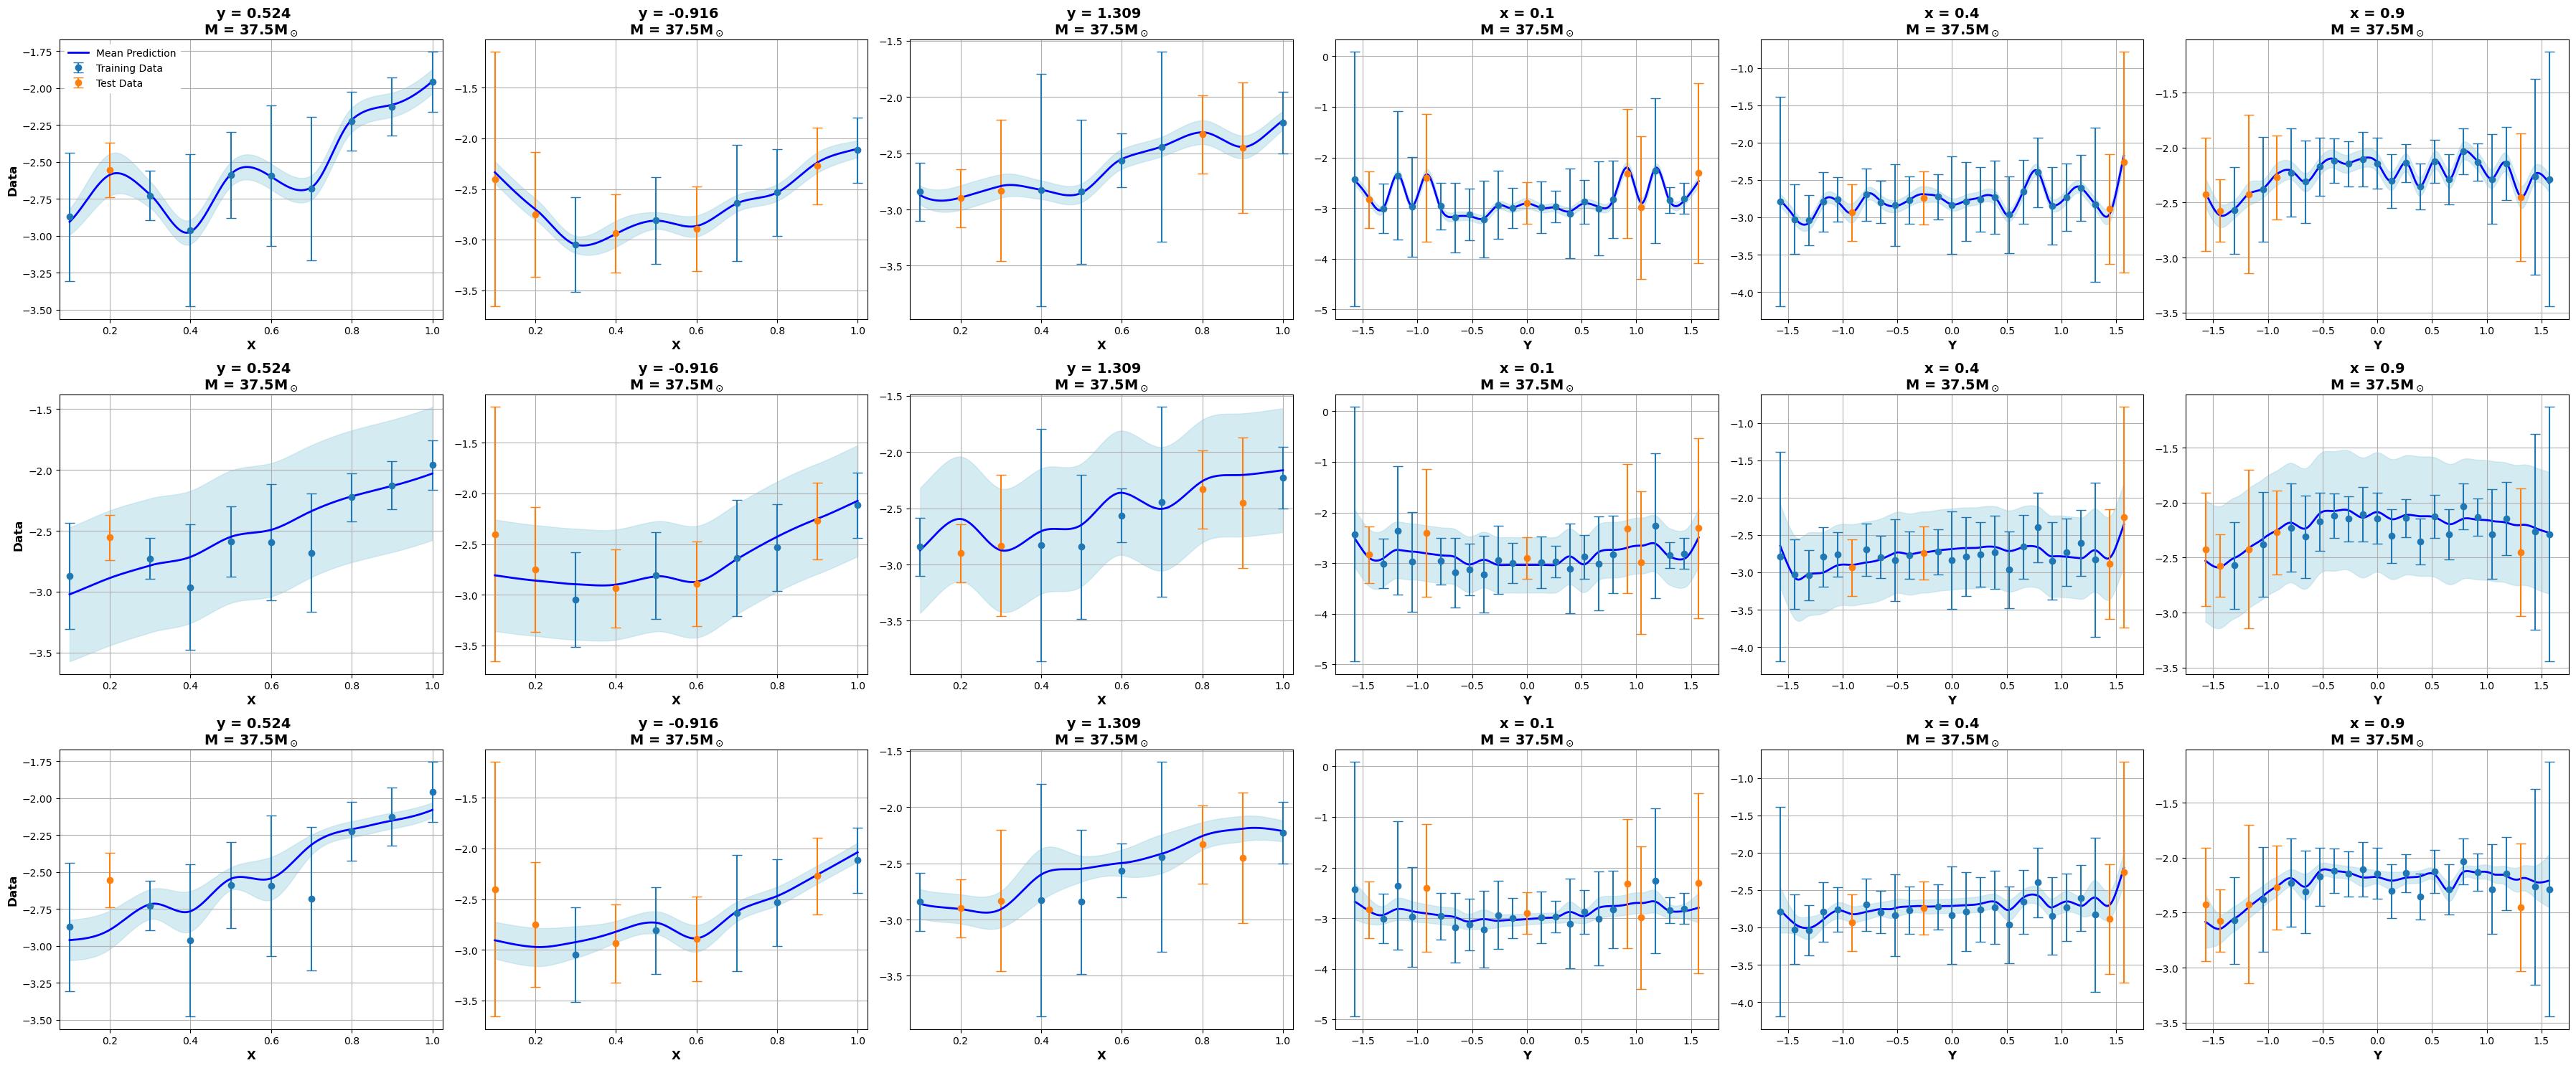

In [ ]:
## Graph
# -----------------------------
# Data Extraction (assumed already defined)
# -----------------------------
x1train = X1_train[:, 0]
y1train = X1_train[:, 1]
x1test  = X1_test[:, 0]
y1test  = X1_test[:, 1]

# -----------------------------
# Fixed coordinate values for interpolation
# -----------------------------
# For fixed-y plots (left 3 subplots on each row)
ypoints_fixed = [0.5235987755982988, -0.9162978572970231, 1.3089969389957472]
x_domain = np.linspace(0, 1, 1000)

# For fixed-x plots (right 3 subplots on each row)
xpoints_fixed = [0.1, 0.4, 0.9]
y_domain = np.linspace(-1.5707963267948966, 1.5707963267948966, 1000)

# -----------------------------
# Set up the grid: 5 rows x 6 columns = 30 subplots
# Each row: left 3 columns = fixed y plots, right 3 columns = fixed x plots
# -----------------------------
nrows = 3
ncols = 6
fig, axes = plt.subplots(nrows, ncols, figsize=(36, 15), sharex=False, sharey=False)

# (Optional) Preallocate an array to store mean predictions for each subplot
# Here we assume each interpolated vector has 1000 points.
store_means = np.zeros((nrows * ncols, 1000))
counter = 0  # to index store_means

# -----------------------------
# Loop over rows and columns to create each subplot
# -----------------------------
for r in range(nrows):
    for c in range(ncols):
        ax = axes[r, c]
        
        # --- Left 3 subplots: Fixed y plots ---
        if c < 3:
            # Select the fixed y value based on the column index (0,1,2)
            y_val = ypoints_fixed[c]
            
            # Interpolate mean and std along the x-domain at the fixed y value
            z_mean = griddata((xm1, ym1), fits[r,:], (x_domain, y_val), method="cubic")
            z_std  = griddata((xm1, ym1), stds[r,:], (x_domain, y_val), method="cubic")
            store_means[counter, :] = z_mean
            
            # Identify training and test points (close to y_val)
            train_idx = np.isclose(y1train, y_val)
            test_idx  = np.isclose(y1test, y_val)
            
            # Plot training and test data with error bars
            ax.errorbar(x1train[train_idx].ravel(), D1_train[train_idx].ravel(),
                        yerr=E1_train[train_idx].ravel(), fmt='o', capsize=5,
                        label='Training Data')
            ax.errorbar(x1test[test_idx].ravel(), D1_test[test_idx].ravel(),
                        yerr=E1_test[test_idx].ravel(), fmt='o', capsize=5,
                        label='Test Data')
            
            # Plot the mean prediction and 95% confidence interval
            ax.plot(x_domain, z_mean, label='Mean Prediction', color='blue', linewidth=2)
            ax.fill_between(x_domain, z_mean - 2*z_std, z_mean + 2*z_std,
                            color='lightblue', alpha=0.5)

            
            # Set axis labels and limits
            ax.set_xlim((0.075, 1.025))
            ax.set_xlabel('X', fontsize=12, weight='bold')
            title = f" y = {round(y_val, 3)}\nM = 37.5M$_\\odot$"
            ax.set_title(title, fontsize=14, weight='bold')
            ax.grid(True)
        
        # --- Right 3 subplots: Fixed x plots ---
        else:
            # For fixed-x plots, use column index c-3 (i.e. 0,1,2)
            x_val = xpoints_fixed[c - 3]
            
            # Interpolate mean and std along the y-domain at the fixed x value
            z_mean = griddata((xm1, ym1), fits[r,:], (x_val, y_domain), method="cubic")
            z_std  = griddata((xm1, ym1), stds[r,:], (x_val, y_domain), method="cubic")
            store_means[counter, :] = z_mean
            
            # Identify training and test points (close to x_val)
            train_idx = np.isclose(x1train, x_val)
            test_idx  = np.isclose(x1test, x_val)
            
            # Plot the mean prediction (with y-domain as x-axis here) and error bars
            ax.plot(y_domain, z_mean, label='Mean Prediction', color='blue', linewidth=2)
            ax.errorbar(y1train[train_idx].ravel(), D1_train[train_idx].ravel(),
                        yerr=E1_train[train_idx].ravel(), fmt='o', capsize=5,
                        label='Training Data')
            ax.errorbar(y1test[test_idx].ravel(), D1_test[test_idx].ravel(),
                        yerr=E1_test[test_idx].ravel(), fmt='o', capsize=5,
                        label='Test Data')
            ax.fill_between(y_domain, z_mean - 2*z_std, z_mean + 2*z_std,
                            color='lightblue', alpha=0.5)
            
            # Set axis labels and limits
            ax.set_xlim((-1.75, 1.75))
            ax.set_xlabel('Y', fontsize=12, weight='bold')
            title = f"x = {round(x_val, 3)}\nM = 37.5M$_\\odot$"
            ax.set_title(title, fontsize=14, weight='bold')
            ax.grid(True)
        
        counter += 1

# -----------------------------
# Final touches: Set a common y-label for leftmost subplots and add legend to one subplot
# -----------------------------
for r in range(nrows):
    axes[r, 0].set_ylabel('Data', fontsize=12, weight='bold')

# Place the legend in the top-left subplot (adjust location as needed)
legend = axes[0, 0].legend(fontsize=10, loc='upper left', frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')
legend.get_frame().set_alpha(1)

plt.tight_layout()
plt.savefig("Fixed_y_and_x_5x6.png", dpi=300, bbox_inches='tight')
plt.show()